# Tutorial

*All cells executed on dev branch, 3/24/2022*

## Prerequisites.

#### Download and install Miniconda, Anaconda, or Conda.

https://docs.conda.io/en/latest/miniconda.html

### Create the Conda environment.

```
conda env create --file conda\win.yml
conda activate tyche
pip install mip
```

#### Activate the Tyche environment.

```
conda activate tyche
```

## Set up.

### Import packages.

#### Import the system packages.

In [1]:
import os
import sys

#### Add the main Tyche packages to the search path.

In [2]:
sys.path.insert(1, os.path.abspath("../src"))

#### Import tyche and related packages.

In [3]:
import numpy             as np
import matplotlib.pyplot as pl
import pandas            as pd
import seaborn           as sb
import tyche             as ty

## Example problem: wind turbines.

Here is a highly simplified and approximate model for a wind turbine.

### Environmental constants.

*   Wind sheer exponent: $\alpha = 0.16$

### Scale of operations.

*   Project scale: $S$.
*   Rotor diameter: $R = 70 \cdot S^\frac{1}{2+3\alpha} ~\textrm{m}$.
*   Hub height: $H = 65 \cdot S^\frac{1}{2+3\alpha} ~\textrm{m}$.
*   Machine rating: $M = 1500 \cdot S ~\textrm{kW}$. 

### Production.

*   Annual energy production: $4312 \cdot S ~\textrm{MWh}$

### Design parameters.

*   Rotor design: $\rho \in [0, 1]$, with $\rho_0 = 0$.
*   Drive design: $\delta \in [0.8, 0.90]$, with $\delta_0 = 0.90$.
*   Tower design: $\tau \in [0.5, 1.0]$, with $\tau_0 = 1.0$.
*   BOS factor: $\beta \in [0.5, 1.0]$, with $\beta_0 = 1.0$.
*   O&M factor: $\mu \in [0.5, 1.0]$, with $\mu_0 = 1.0$.

### Costs.

*   Rotor: $1.6 \cdot R^{2.8} - 60000 \cdot \rho ~\textrm{USD}$.
*   Drive, nacelle, systems: $900 \cdot M^\delta ~\textrm{USD}$.
*   Tower: $0.015 \cdot R^{2.8} \cdot H^\tau ~\textrm{USD}$.
*   Balance of system: $250 \cdot \beta \cdot M ~\textrm{USD}$.
*   Replacements: $10.6 \cdot M ~\textrm{USD}$.
*   O&M: $20 \cdot \mu \cdot M ~\textrm{USD}$.
*   Land lease: $3.5 \cdot M ~\textrm{USD}$.

### Metrics.

*   Capacity factor: $32.82~\%$

## Design the technology model.

### Technology name.

Choose a unique name for the technology being modeled. *In this example we'll call the technology `Wind Turbine`.*

Also choose a unique name for the default, reference, or base-case scenario. *In this example, we'll call the default scenario `Reference`.*

### Dimensions and indices.

Decide which quantities will be tracked as indices in the model, and settle on their units of measurment and default values:
1.  Types of capital costs. *In this example we have . . .*
    *   Rotor
    *   Drive
    *   Tower
    *   BOS
2.  Types of fixed cost. *In this example we have . . .*
    *   Replacements
    *   O&M
    *   Land
3.  Inputs to the process. *In this example we have . . .*
    *   Wind
4.  Outputs from the process. *In this example we have . . .*
    *   Electricity
5.  Metrics. *In this example we have . . .*
    *   Cost
    *   LCOE
    *   CF
    *   AEP
6.  Parameters. *In this example we have . . .*
    *   Rotor design ($\rho$)
    *   Drive design ($\delta$)
    *   Tower design ($\tau$)
    *   BOS factor ($\beta$)
    *   O&M factor ($\mu$)

Note that in each category, the numeric indices for each item are numbered with integers starting from zero.

See the [model](https://tyche.live/doc-src/formulation.html) and [database](https://tyche.live/doc-src/database.html) documentation for more details.

### Create the `indices` table.

Enter the data for your model in the tab-delimited-value file [tutorial/data/indices.tsv](data/).

Check to see that the data file reads correctly:

In [4]:
my_designs = ty.Designs("data")
my_designs.indices.reset_index("Index").sort_values(["Type", "Offset"])

,,Index,Offset,Description,Notes
Technology,Type,,,,


Check your `indices` table against the following:

In [5]:
answers_designs = ty.Designs("answers")
answers_designs.indices.reset_index("Index").sort_values(["Type", "Offset"])

Index  Offset  \
Technology   Type                            
Wind Turbine Capital         Rotor       0   
             Capital         Drive       1   
             Capital         Tower       2   
             Capital           BOS       3   
             Fixed    Replacements       0   
             Fixed             O&M       1   
             Fixed            Land       2   
             Input            Wind       0   
             Metric           Cost       0   
             Metric           LCOE       1   
             Metric             CF       2   
             Metric            AEP       3   
             Output    Electricity       0   

                                                            Description Notes  
Technology   Type                                                              
Wind Turbine Capital        Rotor blades, hub, bearings, spinner, nose.        
             Capital  Drive, gearbox, bearings, electronics, frame, ...        
             Capital                                         The tower.        
             Capital                    Foundations, roads, civil work.        
             Fixed                              Replacement components.        
             Fixed                          Operations and maintenance.        
             Fixed                                          Land lease.        
             Input    Just a placeholder because at least one input ...        
             Metric                           Cost of the wind turbine.        
             Metric                           Levelized cost of energy.        
             Metric                                    Capacity factor.        
             Metric                           Annual energy production.        
             Output                               Annual energy output.

### Create the `results` table.

Enter the data for the units of measure in your model in the tab-delimited-value file [tutorial/data/results.tsv](data/).

Check to see that the data file reads correctly:

In [6]:
my_designs = ty.Designs("data")
my_designs.results

,,,Units,Notes
Technology,Variable,Index,,


Check your `results` table against the following:

In [7]:
answers_designs = ty.Designs("answers")
answers_designs.results

Units Notes
Technology   Variable Index                              
Wind Turbine Cost     Cost                $/turbine      
             Metric   AEP          MWh/turbine/year      
                      CF                      %/100      
                      Cost           $/turbine/year      
                      LCOE                    $/kWh      
             Output   Electricity       kWh/turbine

### Create the `designs` table.

In order to introduce stochasticity into the reference case, let's assume that the turbine lifetime is a triangular distribution from 8 years to 10 years, with a mode of 8.6 years. We use [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) for probability distributions and the function `triang` is described [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.triang.html#scipy.stats.triang). Prefix calls to `scipy.stats` with `st.`, to this triangular distribution is entered into the design table as `st.triang(0.3, 8.0, 2.0)`.

Enter the data for your model in the tab-delimited-value file [tutorial/data/designs.tsv](data/).

Check to see that the data file reads correctly:

In [8]:
my_designs = ty.Designs("data")
my_designs.designs.reset_index(["Variable", "Index"]).sort_values(["Variable", "Index"])

,,Variable,Index,Value,Units,Notes
Technology,Scenario,,,,,


Check your `designs` table against the following:

In [9]:
answers_designs = ty.Designs("answers")
answers_designs.designs.xs("Reference", level = "Scenario", drop_level = False).reset_index(["Variable", "Index"]).sort_values(["Variable", "Index"])

Variable        Index  \
Technology   Scenario                                    
Wind Turbine Reference              Input         Wind   
             Reference   Input efficiency         Wind   
             Reference        Input price         Wind   
             Reference           Lifetime          BOS   
             Reference           Lifetime        Drive   
             Reference           Lifetime        Rotor   
             Reference           Lifetime        Tower   
             Reference  Output efficiency  Electricity   
             Reference       Output price  Electricity   
             Reference              Scale          NaN   

                                           Value  Units  \
Technology   Scenario                                     
Wind Turbine Reference                      10.0    m/s   
             Reference                     0.593  %/100   
             Reference                         0    n/a   
             Reference  st.triang(0.3, 8.0, 2.0)   year   
             Reference  st.triang(0.3, 8.0, 2.0)   year   
             Reference  st.triang(0.3, 8.0, 2.0)   year   
             Reference  st.triang(0.3, 8.0, 2.0)   year   
             Reference                    0.3282  %/100   
             Reference                         0  $/kWh   
             Reference                         1  %/100   

                                                                    Notes  
Technology   Scenario                                                      
Wind Turbine Reference                           Wind speed at 50 meters.  
             Reference                                          Betz law.  
             Reference                                      Wind is free.  
             Reference         Reciprocal of the capital-recovery factor.  
             Reference         Reciprocal of the capital-recovery factor.  
             Reference         Reciprocal of the capital-recovery factor.  
             Reference         Reciprocal of the capital-recovery factor.  
             Reference                                   Capacity factor.  
             Reference                              Not tracking revenue.  
             Reference  Scale of operations, relative to a 1.5MW turbine.

### Create the `parameters` table.

Enter the data for your model in the tab-delimited-value file [tutorial/data/parameters.tsv](data/).

Check to see that the data file reads correctly:

In [10]:
my_designs = ty.Designs("data")
my_designs.parameters.reset_index("Parameter").sort_values("Offset")

,,Parameter,Offset,Value,Units,Notes
Technology,Scenario,,,,,


Check your `parameters` table against the following:

In [11]:
answers_designs = ty.Designs("answers")
answers_designs.parameters.xs("Reference", level = "Scenario", drop_level = False).reset_index("Parameter").sort_values("Offset")

Parameter  Offset Value Units  Notes
Technology   Scenario                                          
Wind Turbine Reference  Rotor design       0     0     1    rho
             Reference  Drive design       1  0.90     1  delta
             Reference  Tower design       2     1     1    tau
             Reference    BOS factor       3     1     1   beta
             Reference    O&M factor       4     1     1     mu

## Implement the technology model.

The implementation of a technology model consists of a capital cost function, a fixed cost function, a production function, and a metrics function.

See the [model](https://tyche.live/doc-src/formulation.html) documentation for more details.

The [src/technology/](../src/technology/) folder has examples of several technology models.

#### Capital cost function.

The capital cost function takes the scale of the operations and the array of technology parameters as arguments and it returns the capital costs for the technology.

Implement the capital cost function for your technology in the file [tutorial/my_technology.py](./).

In [12]:
def capital_cost(scale, parameter):
  """
  Capital cost function.

  Parameters
  ----------
  scale : float
    The scale of operation.
  parameter : array
    The technological parameterization.
  """

  # Stack the costs for each category into a single array that we return.
  return np.stack([
      
  ])

Compare your function to the following:

In [13]:
def answers_capital_cost(scale, parameter):
  """
  Capital cost function.

  Parameters
  ----------
  scale : float
    The scale of operation.
  parameter : array
    The technological parameterization.
  """

  # We aren't varying the wind sheer exponent.
  alpha = 0.16

  # It is handy to copy the elements of the parameter array into meaningful variable names.
  # Not all of these parameters are used in the calculations, but they are read in here for
  # demonstration purposes.
  # There can be as many or as few parameters as needed to implement the technology-specific
  # calculations.
  rho   = parameter[0]
  delta = parameter[1]
  tau   = parameter[2]
  beta  = parameter[3]
  mu    = parameter[4]

  # Compute the rotor diamter, hub height, and machine rating.
  r = 70 * scale**(1 / (2 + 3 * alpha))
  h = 65 * scale**(1 / (2 + 3 * alpha))
  m = 1500 * scale

  # Compute the components of capital cost.
  rotor = 1.6 * r**2.8 - 60000 * rho
  drive = 900 * m**delta
  tower = 0.015 * r**2.8 * h**tau
  bos   = 250 * beta * m

  # Stack the costs for each category into a single array that we return.
  return np.stack([
      rotor,
      drive,
      tower,
      bos,
  ])

Test this for the reference case:

In [14]:
example_capital = answers_capital_cost(1, [0, 0.9, 1, 1, 1])
example_capital

array([234635.91808147, 649717.61674841, 142981.2625809 , 375000.        ])

Interpretation:
*   Rotor: \$235k
*   Drive: \$649k
*   Tower: \$143k
*   BOS: \$375k

#### Fixed cost function.

The fixed cost function takes the scale of the operations and the array of technology parameters as arguments and it returns the fixed costs for the technology.

Implement the fixed cost function for your technology in the file [tutorial/my_technology.py](./).

In [15]:
def fixed_cost(scale, parameter):
  """
  Capital cost function.

  Parameters
  ----------
  scale : float
    The scale of operation.
  parameter : array
    The technological parameterization.
  """
  # Stack the costs for each category into a single array that we return.
  return np.stack([

  ])

Compare your function to the following:

In [16]:
def answers_fixed_cost(scale, parameter):
  """
  Capital cost function.

  Parameters
  ----------
  scale : float
    The scale of operation.
  parameter : array
    The technological parameterization.
  """

  # We aren't varying the wind sheer exponent.
  alpha = 0.16

  # It is handy to copy the elements of the parameter array into meaningful variable names.
  rho   = parameter[0]
  delta = parameter[1]
  tau   = parameter[2]
  beta  = parameter[3]
  mu    = parameter[4]

  # Compute the rotor diamter, hub height, and machine rating.
  r = 70 * scale**(1 / (2 + 3 * alpha))
  h = 65 * scale**(1 / (2 + 3 * alpha))
  m = 1500 * scale

  # Compute the components of fixed cost.
  replacement            = 10.6 * m
  operations_maintenance = 20 * mu * m
  land_lease             = 3.5 * m

  # Stack the costs for each category into a single array that we return.
  return np.stack([
      replacement,
      operations_maintenance,
      land_lease
  ])

Test this for the reference case:

In [17]:
example_fixed = answers_fixed_cost(1, [0, 0.9, 1, 1, 1])
example_fixed

array([15900., 30000.,  5250.])

Interpretation:
*   Replacement: \$16k/yr
*   O&M: \$30k/yr
*   Land: \$5k/yr

#### Production function.

The production function takes the scale of the operations, the capital costs, the lifetime, the fixed costs, and the array of technology parameters as arguments and it returns the production (outputs) for the technology.

Implement the production function for your technology in the file [tutorial/my_technology.py](./).

In [18]:
def production(scale, capital, lifetime, fixed, input, parameter):
  """
  Production function.

  Parameters
  ----------
  scale : float
    The scale of operation.
  capital : array
    Capital costs.
  lifetime : float
    Technology lifetime.
  fixed : array
    Fixed costs.
  input : array
    Input quantities. 
  parameter : array
    The technological parameterization.
  """

  # Stack the output for each category into a single array that we return.
  return np.stack([

  ])

Compare your function to the following:

In [19]:
def answers_production(scale, capital, lifetime, fixed, input, parameter):
  """
  Production function.

  Parameters
  ----------
  scale : float
    The scale of operation.
  capital : array
    Capital costs.
  lifetime : float
    Technology lifetime.
  fixed : array
    Fixed costs.
  input : array
    Input quantities. 
  parameter : array
    The technological parameterization.
  """

  # We aren't varying the wind sheer exponent.
  alpha = 0.16

  # It is handy to copy the elements of the parameter array into meaningful variable names.
  rho   = parameter[0]
  delta = parameter[1]
  tau   = parameter[2]
  beta  = parameter[3]
  mu    = parameter[4]

  # Compute the production of electricity.
  electricity = 4312 * scale / 0.3282

  # Stack the output for each category into a single array that we return.
  return np.stack([
      electricity,
  ])

Test this for the reference case:

In [20]:
example_production = answers_production(
    1,                  # Scale
    example_capital,    # Capital
    [8.6, 8.6, 8.6],    # Lifetimes
    example_fixed,      # Fixed costs
    [0],                # Inputs
    [0, 0.9, 1, 1, 1],  # Parameters
)
example_production

array([13138.33028641])

Interpretation:
*   Rated annual production: 13 GW

#### Metric function.

The metric function takes information on costs, inputs, outputs, and parameters and it returns the metrics for the technology.

Implement the metrics function for your technology in the file [tutorial/my_technology.py](./).

In [21]:
def metrics(scale, capital, lifetime, fixed, input_raw, input, input_price, output_raw, output, cost, parameter):
  """
  Metrics function.

  Parameters
  ----------
  scale : float
    The scale of operation.
  capital : array
    Capital costs.
  lifetime : float
    Technology lifetime.
  fixed : array
    Fixed costs.
  input_raw : array
    Raw input quantities (before losses).
  input : array
    Input quantities. 
  output_raw : array
    Raw output quantities (before losses).
  output : array
    Output quantities. 
  cost : array
    Costs.
  parameter : array
    The technological parameterization.
  """

  # Package results.
  return np.stack([

  ])

Compare your function to the following:

In [22]:
def answers_metrics(scale, capital, lifetime, fixed, input_raw, input,input_price, output_raw, output, cost, parameter):
  """
  Metrics function.

  Parameters
  ----------
  scale : float
    The scale of operation.
  capital : array
    Capital costs.
  lifetime : float
    Technology lifetime.
  fixed : array
    Fixed costs.
  input_raw : array
    Raw input quantities (before losses).
  input : array
    Input quantities. 
  output_raw : array
    Raw output quantities (before losses).
  output : array
    Output quantities. 
  cost : array
    Costs.
  parameter : array
    The technological parameterization.
  """

  # We aren't varying the wind sheer exponent.
  alpha = 0.16

  # It is handy to copy the elements of the parameter array into meaningful variable names.
  rho   = parameter[0]
  delta = parameter[1]
  tau   = parameter[2]
  beta  = parameter[3]
  mu    = parameter[4]

  # Compute the metrics.
  lcoe = cost / output[0] / 1000
  cf = output[0] / output_raw[0]
  aep = output[0]

  # Package results.
  return np.stack([
    cost,
    lcoe,
    cf  ,
    aep ,
  ])

Test this for the reference case:

In [23]:
example_metrics = answers_metrics(
    1,                 # Scale
    example_capital,   # Capital
    [8.6, 8.6, 8.6],   # Lifetimes
    example_fixed,     # Fixed costs
    [0],               # Input_raw (idealized amount)
    [0],               # Input (accounting for losses)
    [0],               # Input price (wind is free)
    example_production,                              # Output_raw (idealized amount)
    example_production * 0.3282,                     # Output (accounting for losses)
    sum(example_capital / 8.6) + sum(example_fixed), # Cost
    [0, 0.9, 1, 1, 1], # Parameters
)
example_metrics

array([2.14212186e+05, 4.96781507e-02, 3.28200000e-01, 4.31200000e+03])

Interpretation:
*   Levelized cost: \$214k/yr
*   LCOE: \$0.05/kWh
*   Capacity factor: 32.82%
*   Annual energy production: 4312 MWh/yr

### Create the `functions` table.

Enter the technology name and any notes for your model in the tab-delimited-value file [tutorial/data/functions.tsv](data/). You can also edit the module or function names in this table, if you changed them.

Check to see that the data file reads correctly:

In [24]:
my_designs = ty.Designs("data")
my_designs.functions

,Style,Module,Capital,Fixed,Production,Metrics,Notes
Technology,,,,,,,
My Technology,numpy,my_technology,capital_cost,fixed_cost,production,metrics,my notes


Compare your `functions` table to the following:

In [25]:
answers_designs = ty.Designs("answers")
answers_designs.functions

,Style,Module,Capital,Fixed,Production,Metrics,Notes
Technology,,,,,,,
Wind Turbine,numpy,answers_technology,capital_cost,fixed_cost,production,metrics,


## Simulate the base case or reference scenario.

### Load the data.

In [26]:
answers_designs = ty.Designs("answers")

### Compile the production and metric functions for each technology in the dataset.

In [27]:
answers_designs.compile()

Recall that the lifetime of the wind turbine is a random variable. Let's compute an ensemble of 1000 simulations for the reference case.

In [28]:
answers_reference = answers_designs.evaluate_scenarios(
    sample_count=1000
).xs(
    "Reference",
    level = "Scenario",
    drop_level = False
)
answers_reference

Evaluating Wind Turbine


Value  \
Technology   Scenario  Sample Variable Index                        
Wind Turbine Reference 1      Cost     Cost         204672.958443   
                              Metric   AEP            4312.000000   
                                       CF                0.328200   
                                       Cost         204672.958443   
                                       LCOE              0.047466   
...                                                           ...   
                       1000   Metric   AEP            4312.000000   
                                       CF                0.328200   
                                       Cost         206835.469806   
                                       LCOE              0.047967   
                              Output   Electricity    4312.000000   

                                                               Units  
Technology   Scenario  Sample Variable Index                          
Wind Turbine Reference 1      Cost     Cost                $/turbine  
                              Metric   AEP          MWh/turbine/year  
                                       CF                      %/100  
                                       Cost           $/turbine/year  
                                       LCOE                    $/kWh  
...                                                              ...  
                       1000   Metric   AEP          MWh/turbine/year  
                                       CF                      %/100  
                                       Cost           $/turbine/year  
                                       LCOE                    $/kWh  
                              Output   Electricity       kWh/turbine  

[6000 rows x 2 columns]

Here is a violin plot for the LCOE:

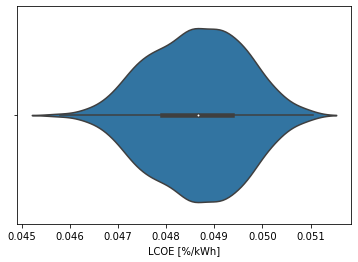

In [29]:
sb.violinplot(
    answers_reference.xs(
        ("Wind Turbine", "Reference", "Metric", "LCOE"),
        level = ("Technology", "Scenario", "Variable", "Index")
    )["Value"]
).set(xlabel = "LCOE [%/kWh]");

## Simulate effects of R&D.

### Expert elicitation

Let's say that we interview experts about three intensities of R&D investment in each of rotor, drive, and tower design. They provide us with triangular probability distributions for the $\rho$, $\delta$, and $\tau$ parameters. Furthermore, let's say that they disagree on the results of intense R&D on tower design, where 70% of the experts provide a more optimistic assessment.

In [30]:
answers_designs.parameters.iloc[
    answers_designs.parameters.index.get_level_values(2).isin(
        ["Rotor design", "Drive design", "Tower design"]
    )
]

Offset  \
Technology   Scenario          Parameter              
Wind Turbine Casual Drive R&D  Drive design       1   
                               Rotor design       0   
                               Tower design       2   
             Casual Rotor R&D  Drive design       1   
                               Rotor design       0   
                               Tower design       2   
             Casual Tower R&D  Drive design       1   
                               Rotor design       0   
                               Tower design       2   
             Focused Drive R&D Drive design       1   
                               Rotor design       0   
                               Tower design       2   
             Focused Rotor R&D Drive design       1   
                               Rotor design       0   
                               Tower design       2   
             Focused Tower R&D Drive design       1   
                               Rotor design       0   
                               Tower design       2   
             Intense Drive R&D Drive design       1   
                               Rotor design       0   
                               Tower design       2   
             Intense Rotor R&D Drive design       1   
                               Rotor design       0   
                               Tower design       2   
             Intense Tower R&D Drive design       1   
                               Rotor design       0   
                               Tower design       2   
             Reference         Drive design       1   
                               Rotor design       0   
                               Tower design       2   

                                                                                         Value  \
Technology   Scenario          Parameter                                                         
Wind Turbine Casual Drive R&D  Drive design                         st.triang(0.5, 0.87, 0.03)   
                               Rotor design                                                  0   
                               Tower design                                                  1   
             Casual Rotor R&D  Drive design                                               0.90   
                               Rotor design                           st.triang(0.5, 0.0, 0.4)   
                               Tower design                                                  1   
             Casual Tower R&D  Drive design                                               0.90   
                               Rotor design                                                  0   
                               Tower design                           st.triang(0.5, 0.8, 0.2)   
             Focused Drive R&D Drive design                         st.triang(0.5, 0.84, 0.06)   
                               Rotor design                                                  0   
                               Tower design                                                  1   
             Focused Rotor R&D Drive design                                               0.90   
                               Rotor design                           st.triang(0.5, 0.3, 0.4)   
                               Tower design                                                  1   
             Focused Tower R&D Drive design                                               0.90   
                               Rotor design                                                  0   
                               Tower design                           st.triang(0.5, 0.6, 0.4)   
             Intense Drive R&D Drive design                         st.triang(0.5, 0.80, 0.10)   
                               Rotor design                                                  0   
                               Tower design                                                  1   
             Intense Rotor R&D

### Simulating implications of expert elicitation.

In [31]:
answers_experts = answers_designs.evaluate_scenarios(sample_count=1000)
answers_experts

Evaluating Wind Turbine


Value  \
Technology   Scenario         Sample Variable Index                        
Wind Turbine Casual Drive R&D 1      Cost     Cost         205328.619176   
                                     Metric   AEP            4312.000000   
                                              CF                0.328200   
                                              Cost         205328.619176   
                                              LCOE              0.047618   
...                                                                  ...   
             Reference        1000   Metric   AEP            4312.000000   
                                              CF                0.328200   
                                              Cost         219544.982128   
                                              LCOE              0.050915   
                                     Output   Electricity    4312.000000   

                                                                      Units  
Technology   Scenario         Sample Variable Index                          
Wind Turbine Casual Drive R&D 1      Cost     Cost                $/turbine  
                                     Metric   AEP          MWh/turbine/year  
                                              CF                      %/100  
                                              Cost           $/turbine/year  
                                              LCOE                    $/kWh  
...                                                                     ...  
             Reference        1000   Metric   AEP          MWh/turbine/year  
                                              CF                      %/100  
                                              Cost           $/turbine/year  
                                              LCOE                    $/kWh  
                                     Output   Electricity       kWh/turbine  

[60000 rows x 2 columns]

Make violin plots showing the implications of the expert opinions

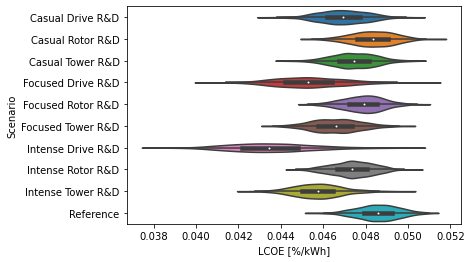

In [32]:
sb.violinplot(
    y = "Scenario",
    x = "Value",
    data = answers_experts.xs(
        ("Wind Turbine", "Metric", "LCOE"),
        level = ("Technology", "Variable", "Index")
    ).reset_index()
).set(xlabel = "LCOE [%/kWh]");

## Analyzing investments.

### Base case.

#### Create the `tranches` table.

To get started, we just want to create on tranche and one category for the base case or reference scenario.

Edit the name of the reference case for your model in the tab-delimited-value file [tutorial/data/tranches.tsv](data/).

Check to see that the data file reads correctly:

In [33]:
my_investments = ty.Investments("data")
my_investments.tranches

,,,Amount,Notes
Category,Tranche,Scenario,,
Example Category,Example Tranche,Base Case,0.0,


Compare your `tranches` table to the following:

In [34]:
answers_investments = ty.Investments("answers")
answers_investments.tranches.xs(
    "Base Case",
    drop_level = False
).reset_index(
).sort_values(
    ["Category", "Amount"]
).set_index(
    ["Category", "Tranche"]
)

,,Scenario,Amount,Notes
Category,Tranche,,,
Base Case,Business as Usual,Reference,0.0,base case


### Create the `investments` table.

To get started, we just want to create one investment for the base case or reference scenario.

Edit the name of the reference case for your model in the tab-delimited-value file [tutorial/data/investments.tsv](data/).

Check to see that the data file reads correctly:

In [35]:
my_investments = ty.Investments("data")
my_investments.investments

,,,Notes
Investment,Category,Tranche,
Example Investment,Example Category,Example Tranche,


Compare your `investments` table to the following:

In [36]:
answers_investments = ty.Investments("answers")
answers_investments.investments

,,,Notes
Investment,Category,Tranche,
No Investment,Base Case,Business as Usual,


### Simulate the base case or reference scenario.

#### Load the data.

In [37]:
answers_designs = ty.Designs("answers")

In [38]:
answers_investments = ty.Investments("answers")

#### Compile the production and metric functions for each technology in the dataset.

In [39]:
answers_designs.compile()

#### Simulate the base case.

In [40]:
answers_investment_results = answers_investments.evaluate_investments(answers_designs, sample_count=1000)

Evaluating Wind Turbine


Here are the metrics for the base case:

In [41]:
answers_investment_results.summary

Value             Units
Investment    Technology   Sample Index                                 
No Investment Wind Turbine 1      AEP      4312.000000  MWh/turbine/year
                                  CF          0.328200             %/100
                                  Cost   212266.133536    $/turbine/year
                                  LCOE        0.049227             $/kWh
                           2      AEP      4312.000000  MWh/turbine/year
...                                                ...               ...
                           999    LCOE        0.050009             $/kWh
                           1000   AEP      4312.000000  MWh/turbine/year
                                  CF          0.328200             %/100
                                  Cost   200965.791297    $/turbine/year
                                  LCOE        0.046606             $/kWh

[4000 rows x 2 columns]

Here is the cost for the base case:

In [42]:
answers_investment_results.amounts

,Amount
Investment,
No Investment,0.0


### Investment cases.

Now we create investment cases corresponding to the scenarios that were the focus of the expert elicitation:

In [43]:
answers_investments.tranches

Amount  \
Category              Tranche                        Scenario                       
Base Case             Business as Usual              Reference                0.0   
Drive Investment Only Large Investment in Drive R&D  Intense Drive R&D  7000000.0   
                      Medium Investment in Drive R&D Focused Drive R&D  3000000.0   
                      No Drive Investment            Reference                0.0   
                      Small Investment in Drive R&D  Casual Drive R&D   2000000.0   
Rotor Investment Only Large Investment in Rotor R&D  Intense Rotor R&D  9000000.0   
                      Medium Investment in Rotor R&D Focused Rotor R&D  3000000.0   
                      No Rotor Investment            Reference                0.0   
                      Small Investment in Rotor R&D  Casual Rotor R&D   1000000.0   
Tower Investment Only Large Investment in Tower R&D  Intense Tower R&D  6000000.0   
                      Medium Investment in Tower R&D Focused Tower R&D  4000000.0   
                      No Tower Investment            Reference                0.0   
                      Small Investment in Tower R&D  Casual Tower R&D   2000000.0   

                                                                            Notes  
Category              Tranche                        Scenario                      
Base Case             Business as Usual              Reference          base case  
Drive Investment Only Large Investment in Drive R&D  Intense Drive R&D             
                      Medium Investment in Drive R&D Focused Drive R&D             
                      No Drive Investment            Reference                     
                      Small Investment in Drive R&D  Casual Drive R&D              
Rotor Investment Only Large Investment in Rotor R&D  Intense Rotor R&D             
                      Medium Investment in Rotor R&D Focused Rotor R&D             
                      No Rotor Investment            Reference                     
                      Small Investment in Rotor R&D  Casual Rotor R&D              
Tower Investment Only Large Investment in Tower R&D  Intense Tower R&D             
                      Medium Investment in Tower R&D Focused Tower R&D             
                      No Tower Investment            Reference                     
                      Small Investment in Tower R&D  Casual Tower R&D

#### Compute costs and metrics for tranches.

Tranches are atomic units for building investment portfolios. Evaluate all of the tranches, so we can assemble them into investments (portfolios).

In [44]:
tranche_results = answers_investments.evaluate_tranches(answers_designs, sample_count=1000)

Evaluating Wind Turbine


The tranche amounts are simple how much each tranche costs.

In [45]:
tranche_results.amounts.reset_index().sort_values(["Category", "Amount"]).set_index(["Category", "Tranche"])

Amount
Category              Tranche                                  
Base Case             Business as Usual                     0.0
Drive Investment Only No Drive Investment                   0.0
                      Small Investment in Drive R&D   2000000.0
                      Medium Investment in Drive R&D  3000000.0
                      Large Investment in Drive R&D   7000000.0
Rotor Investment Only No Rotor Investment                   0.0
                      Small Investment in Rotor R&D   1000000.0
                      Medium Investment in Rotor R&D  3000000.0
                      Large Investment in Rotor R&D   9000000.0
Tower Investment Only No Tower Investment                   0.0
                      Small Investment in Tower R&D   2000000.0
                      Medium Investment in Tower R&D  4000000.0
                      Large Investment in Tower R&D   6000000.0

The tranch metrics show the values of each metric for each member of the ensemble of simulations.

In [46]:
tranche_results.metrics

Value  \
Category              Tranche                       Scenario         Sample Technology   Index                  
Drive Investment Only Small Investment in Drive R&D Casual Drive R&D 1      Wind Turbine AEP      4312.000000   
                                                                                         CF          0.328200   
                                                                                         Cost   203431.718136   
                                                                                         LCOE        0.047178   
                                                                     2      Wind Turbine AEP      4312.000000   
...                                                                                                       ...   
Tower Investment Only No Tower Investment           Reference        999    Wind Turbine LCOE        0.049158   
                                                                     1000   Wind Turbine AEP      4312.000000   
                                                                                         CF          0.328200   
                                                                                         Cost   212520.328887   
                                                                                         LCOE        0.049286   

                                                                                                           Units  
Category              Tranche                       Scenario         Sample Technology   Index                    
Drive Investment Only Small Investment in Drive R&D Casual Drive R&D 1      Wind Turbine AEP    MWh/turbine/year  
                                                                                         CF                %/100  
                                                                                         Cost     $/turbine/year  
                                                                                         LCOE              $/kWh  
                                                                     2      Wind Turbine AEP    MWh/turbine/year  
...                                                                                                          ...  
Tower Investment Only No Tower Investment           Reference        999    Wind Turbine LCOE              $/kWh  
                                                                     1000   Wind Turbine AEP    MWh/turbine/year  
                                                                                         CF                %/100  
                                                                                         Cost     $/turbine/year  
                                                                                         LCOE              $/kWh  

[52000 rows x 2 columns]

#### Prepare results for optimization.

The following will be automated, so we won't go into details here.

In [47]:
z = tranche_results.summary.xs("LCOE", level = "Index", drop_level = False)
z_reference = np.mean(z.xs("Base Case")["Value"])
z = z[z.index.get_level_values(0) != "Base Case"]

#### The `Evaluator` object provides convenient access to the simulation results.

In [48]:
evaluator = ty.Evaluator(
    answers_investments.tranches[
        answers_investments.tranches.index.get_level_values(0) != "Base Case"
    ],
    z
)

#### Query the maximum investments possible in each category.

In [49]:
evaluator.max_amount

,Amount
Category,
Drive Investment Only,7000000.0
Rotor Investment Only,9000000.0
Tower Investment Only,6000000.0


Query the units of measure for each metric.

In [50]:
evaluator.units

,Units
Index,
LCOE,$/kWh


#### Create the optimizer.

In [51]:
optimizer = ty.EpsilonConstraintOptimizer(evaluator)

#### Query the optimum values attainable for each metric.

Because we are using levelized cost of electricity, the optimum value will be the minimum.

In [52]:
metric_max = optimizer.optimum_metrics(sense='min')
metric_max

LCOE    0.137187
Name: Value, dtype: float64

#### Find the lowest LCOE if only \$5M can be spent.

In [53]:
w = optimizer.opt_slsqp(
    "LCOE",
    sense='min',
    total_amount = 5000000,
)
w[1]

'Optimization terminated successfully'

Investment amounts

In [54]:
w[2]

Category
Drive Investment Only    3.000128e+06
Rotor Investment Only    1.670886e-07
Tower Investment Only    1.999872e+06
Name: Amount, dtype: float64

Reduction in metric relative to the base case metric value.

In [55]:
z_reference - w[3]

Index
LCOE   -0.092637
Name: Value, dtype: float64

#### Find the lowest LCOE if only 5M USD can be spent and only 2M USD can be spent in each category.

In [56]:
w = optimizer.opt_slsqp(
    "LCOE",
    sense='min',
    total_amount = 5000000,
    max_amount = pd.Series(
        [2000000, 2000000, 2000000],
        index=["Rotor Investment Only", "Drive Investment Only", "Tower Investment Only"]
    )
)
w[1]

'Optimization terminated successfully'

Investment amounts

In [57]:
w[2]

Category
Drive Investment Only    2000000.0
Rotor Investment Only    1000000.0
Tower Investment Only    2000000.0
Name: Amount, dtype: float64

Resulting metric.

In [58]:
z_reference - w[3]

Index
LCOE   -0.093848
Name: Value, dtype: float64